In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # 1.6.0 버전
# !pip install torch==1.6.0
# !pip install torchvision==0.7.0

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2, 3"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Jan  7 09:03:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:02:00.0 Off |                  N/A |
| 41%   49C    P2    67W / 280W |  11866MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 40%   

In [2]:
torch.__version__

'1.6.0'

## Setup imports

In [3]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, NoiseRobustDiceLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    RandScaleIntensityd,
    RandGaussianNoised,
    RandFlipd,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandShiftIntensityd,
    SpatialPadd,
    RandAffined,
    CastToTyped,
    DeleteItemsd,
    FgBgToIndicesd,
    Rand3DElasticd,
    RandZoomd,
    Rand2DElasticd,
    RandWeightedCropd,
    AsDiscrete,
    SpatialPadd,
    adaptor,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.4.0-194-generic)
Numpy version: 1.18.5
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.0
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [4]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [5]:
train_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/2D_dataset/Train/*/*Low Dose Neck*/*.npy"))
train_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/2D_dataset/Train/*/*Neck Other*/*.npy"))

test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/2D_dataset/Test/*/*Low Dose Neck*/*.npy"))
test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/2D_dataset/Test/*/*Neck Other*/*.npy"))

train_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(train_low_images, train_high_images)]
test_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(test_low_images, test_high_images)]

## Augmentation

In [6]:
# CT에 맞는 Augmentation
from torchvision import transforms
train_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]),   
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

/workspace/sunggu/4.Dose_img2img/dataset/2D_dataset/Train/21297755/2017-12-19 CT, Low Dose Neck With Enhance/000000082.npy
/workspace/sunggu/4.Dose_img2img/dataset/2D_dataset/Train/22231626/2016-12-09 CT, Neck Other With Enhance/000000022.npy
image shape: torch.Size([512, 512])


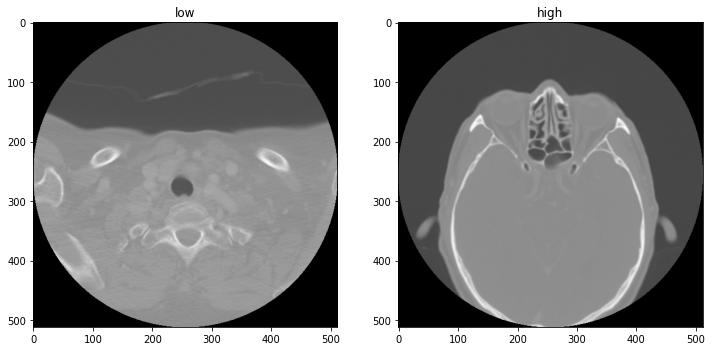

In [7]:
check_ds = Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(low, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(high, cmap="gray")

plt.show()

In [9]:
import multiprocessing
# from torchsampler.imbalanced import ImbalancedDatasetSampler, sunggu_ImbalancedDatasetSampler

# cf) use batch_size=2 to load images and use RandCropByPosNegLabeld
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
train_ds = Dataset(data=train_files, transform=train_transforms)
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.5)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=12, drop_last=True)

CPU 갯수 =  12


## Create Model, Loss, Optimizer

In [10]:
# def lambda_rule(epoch):
#     lr_l = 1.0 - max(0, epoch + 1 - 100) / float(100 + 1)
#     return lr_l

# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

In [11]:
#     if (epoch + 1) > params.decay_epoch:
#         D_A_optimizer.param_groups[0]['lr'] -= params.lrD / (params.num_epochs - params.decay_epoch)
#         D_B_optimizer.param_groups[0]['lr'] -= params.lrD / (params.num_epochs - params.decay_epoch)
#         G_optimizer.param_groups[0]['lr'] -= params.lrG / (params.num_epochs - params.decay_epoch)

In [12]:
def init_net(net, init_type='normal', init_gain=0.02):
    net = torch.nn.DataParallel(net)
    net.to('cuda')        
    init_weights(net, init_type, init_gain=init_gain)
    return net

In [13]:
from Cyclegan_sunggu.model import *
from Cyclegan_sunggu.util import *
import itertools

device = 'cuda'

## 모델
netG_low_2_high = CycleGAN_Generator(in_channels=1, out_channels=1, feature=64, norm='inorm', nblk=9)
netG_high_2_low = CycleGAN_Generator(in_channels=1, out_channels=1, feature=64, norm='inorm', nblk=9)

netD_low = CycleGAN_Discriminator(in_channels=1, out_channels=1, feature=64, norm='inorm')
netD_high = CycleGAN_Discriminator(in_channels=1, out_channels=1, feature=64, norm='inorm')

# ## multi-gpu 사용
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
    
#     netG_low_2_high = init_net(netG_low_2_high, init_type='normal', init_gain=0.02)
#     netG_high_2_low = init_net(netG_high_2_low, init_type='normal', init_gain=0.02)

#     netD_low = init_net(netD_low, init_type='normal', init_gain=0.02)
#     netD_high = init_net(netD_high, init_type='normal', init_gain=0.02)

## 손실함수 정의하기
cycle_loss = nn.L1Loss()
gan_loss = nn.BCELoss()
identity_loss = nn.L1Loss()

## Optimizer 설정하기
optimizer_G = torch.optim.Adam(itertools.chain(netG_low_2_high.parameters(), netG_high_2_low.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_low.parameters(), netD_high.parameters()), lr=2e-4, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.5)

# Generated image pool
from Cyclegan_sunggu.image_pool import ImagePool
num_pool = 50
fake_low_pool = ImagePool(num_pool)
fake_high_pool = ImagePool(num_pool)

In [14]:
# from torchsummary import summary
# input_size = (1,32,320,320)
# summary(model.encoder, input_size, batch_size=-1, device='cpu')

## 모델 이어서 학습하기

In [15]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/Cycle_Gan_2D/epoch_215_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']

netG_low_2_high.load_state_dict(checkpoint['netG_low_2_high_state_dict'])
netG_high_2_low.load_state_dict(checkpoint['netG_high_2_low_state_dict'])

netD_low.load_state_dict(checkpoint['netD_low_state_dict'])
netD_high.load_state_dict(checkpoint['netD_high_state_dict'])


# optimizer_G.load_state_dict(checkpoint['optimizer_G'])
# optimizer_D.load_state_dict(checkpoint['optimizer_G'])

# scheduler.load_state_dict(checkpoint['lr_scheduler'])        

## multi-gpu 사용
if torch.cuda.device_count() > 1:
    
    netG_low_2_high = torch.nn.DataParallel(netG_low_2_high)
    netG_high_2_low = torch.nn.DataParallel(netG_high_2_low)
    
    netD_low = torch.nn.DataParallel(netD_low)
    netD_high = torch.nn.DataParallel(netD_high)
    
    netG_low_2_high.to('cuda')  
    netG_high_2_low.to('cuda')  
    netD_low.to('cuda')  
    netD_high.to('cuda')  


###### 필요한 Weight만 Load

In [16]:
# # Before
# model_dict = model.state_dict()
# print("이전 weight = ", model_dict['encoder._conv_stem.weight'][0])

# load_dir = '/workspace/sunggu/1.Hemorrhage/monai_experiment/model/Efficient3d_conv2d_Aux/'
# pretrained_dict =  torch.load(os.path.join(load_dir, "epoch_0_best_metric_model.pth")) 

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

# # After
# print("이후 weight = ", model_dict['encoder._conv_stem.weight'][0])

## Train

In [17]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x: (x * 0.5) + 0.5

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
st_epoch = 0

epoch_num = 600
val_interval = 10

epoch_train_loss_list = list()
epoch_val_loss_list = list()

epoch_train_metric_list = list()
epoch_val_metric_list = list()

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/Cycle_Gan_2D_2')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/Cycle_Gan_2D_2/'

low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'Cycle_Gan_2D_2'+'/low2high/'
high2low_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'Cycle_Gan_2D_2'+'/high2low/'

# 모델 save폴더 만들기
if not os.path.exists(root_dir):
    os.makedirs(root_dir, mode=0o777)

if not os.path.exists(low2high_png_dir):
    os.makedirs(low2high_png_dir, mode=0o777)
if not os.path.exists(high2low_png_dir):
    os.makedirs(high2low_png_dir, mode=0o777)

    
for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    netG_low_2_high.train()
    netG_high_2_low.train()
    netD_low.train()
    netD_high.train()
    
    # Loss 선언
    loss_G_low2high_train = []
    loss_G_high2low_train = []
    
    loss_D_low_train = []
    loss_D_high_train = []
    
    loss_cycle_low_train = []
    loss_cycle_high_train = []
    
    loss_ident_low_train = []
    loss_ident_high_train = []

    train_iterator = tqdm(train_loader, desc='Train', file=sys.stdout)    
    for batch_data in train_iterator:
        
        input_low = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)

        # Forward Generator
        output_high = netG_low_2_high(input_low)
        output_low = netG_high_2_low(input_high)
        recon_high = netG_low_2_high(output_low)
        recon_low = netG_high_2_low(output_high)
        
        # Backward Discriminator
        set_requires_grad([netD_low, netD_high], True)
        optimizer_D.zero_grad()
        
            # backward Discriminator LOW (Discriminator Gan Loss)
        pred_real_low = netD_low(input_low)
        # POOL
        output_low = fake_low_pool.query(output_low)
        pred_fake_low = netD_low(output_low.detach())
        
        loss_D_low_real = gan_loss(pred_real_low, torch.ones_like(pred_real_low))  # 진짜는 '1'으로
        loss_D_low_fake = gan_loss(pred_fake_low, torch.zeros_like(pred_fake_low)) # 가짜는 '0'으로
        loss_D_low = 0.5 * (loss_D_low_real + loss_D_low_fake)
            # backward Discriminator HIGH (Discriminator Gan Loss)
        pred_real_high = netD_high(input_high)
        # POOL
        output_high = fake_high_pool.query(output_high)
        pred_fake_high = netD_high(output_high.detach())
        loss_D_high_real = gan_loss(pred_real_high, torch.ones_like(pred_real_high))
        loss_D_high_fake = gan_loss(pred_fake_high, torch.zeros_like(pred_fake_high))
        loss_D_high = 0.5 * (loss_D_high_real + loss_D_high_fake)

        loss_D = loss_D_high + loss_D_low
        loss_D.backward()
        optimizer_D.step()

        # Backward Generator
        set_requires_grad([netD_low, netD_high], False)
        optimizer_G.zero_grad()
        
            # Gerator Gan Loss
        pred_fake_low = netD_low(output_low)
        pred_fake_high = netD_high(output_high)
        loss_G_low2high = gan_loss(pred_fake_low, torch.ones_like(pred_fake_low))
        loss_G_high2low = gan_loss(pred_fake_high, torch.ones_like(pred_fake_high))
            
            # Cycle Loss
        loss_cycle_low = cycle_loss(input_low, recon_low)
        loss_cycle_high = cycle_loss(input_high, recon_high)
            
            # Identity Loss
        ident_low = netG_high_2_low(input_low)
        ident_high = netG_low_2_high(input_high)
        loss_ident_low = identity_loss(input_low, ident_low)
        loss_ident_high = identity_loss(input_high, ident_high)

        loss_G = (loss_G_low2high + loss_G_high2low) + \
                 10.0 * (loss_cycle_low + loss_cycle_high) + \
                 10.0 * 0.5 * (loss_ident_low + loss_ident_high)

        loss_G.backward()
        optimizer_G.step()

        # 손실함수 계산
        loss_G_low2high_train += [loss_G_low2high.item()]
        loss_G_high2low_train += [loss_G_high2low.item()]

        loss_D_low_train += [loss_D_low.item()]
        loss_D_high_train += [loss_D_high.item()]

        loss_cycle_low_train += [loss_cycle_low.item()]
        loss_cycle_high_train += [loss_cycle_high.item()]

        loss_ident_low_train += [loss_ident_low.item()]
        loss_ident_high_train += [loss_ident_high.item()]
        
        
    print( "Generator Loss       [Low to High] = %.4f" %np.mean(loss_G_low2high_train) ) 
    print( "Generator Loss       [High to Low] = %.4f" %np.mean(loss_G_high2low_train) )
    print( "Discriminator LOss   [Low]         = %.4f" %np.mean(loss_D_low_train) )
    print( "Discriminator Loss   [High]        = %.4f" %np.mean(loss_D_high_train) )

    print( "Cycle Loss           [Low]         = %.4f" %np.mean(loss_cycle_low_train) )
    print( "Cycle Loss           [High]        = %.4f" %np.mean(loss_cycle_high_train) )

    print( "Identity Loss        [Low]         = %.4f" %np.mean(loss_ident_low_train) )
    print( "Identity Loss        [High]        = %.4f" %np.mean(loss_ident_high_train) )

    total_loss = np.mean(loss_G_low2high_train) + np.mean(loss_G_high2low_train) +\
                 np.mean(loss_D_low_train)      + np.mean(loss_D_high_train)     +\
                 np.mean(loss_D_high_train)     + np.mean(loss_cycle_high_train) +\
                 np.mean(loss_ident_low_train)  + np.mean(loss_ident_high_train)

    print( "TOTAL Loss                         = %.4f" %total_loss )

    # Tensorboard 저장하기
    input_low = fn_tonumpy((input_low))
    input_high = fn_tonumpy((input_high))
    output_low = fn_tonumpy((output_low))
    output_high = fn_tonumpy((output_high))

    input_low = np.clip(input_low, a_min=0, a_max=1)
    input_high = np.clip(input_high, a_min=0, a_max=1)
    output_low = np.clip(output_low, a_min=0, a_max=1)
    output_high = np.clip(output_high, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png', input_low[0].squeeze(), cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output_high[0].squeeze(), cmap="gray")
    plt.imsave(high2low_png_dir+'epoch_'+str(epoch)+'_input_high.png', input_high[0].squeeze(), cmap="gray")
    plt.imsave(high2low_png_dir+'epoch_'+str(epoch)+'_output_low.png', output_low[0].squeeze(), cmap="gray")

    writer.add_image('input_low', input_low, epoch, dataformats='NHWC')
    writer.add_image('input_high', input_high, epoch, dataformats='NHWC')
    writer.add_image('output_low', output_low, epoch, dataformats='NHWC')
    writer.add_image('output_high', output_high, epoch, dataformats='NHWC')
            
    # Loss Write    
    writer.add_scalar('loss_G_low2high', np.mean(loss_G_low2high_train), epoch)
    writer.add_scalar('loss_G_high2low', np.mean(loss_G_high2low_train), epoch)

    writer.add_scalar('loss_D_low', np.mean(loss_D_low_train), epoch)
    writer.add_scalar('loss_D_high', np.mean(loss_D_high_train), epoch)

    writer.add_scalar('loss_cycle_low', np.mean(loss_cycle_low_train), epoch)
    writer.add_scalar('loss_cycle_high', np.mean(loss_cycle_high_train), epoch)

    writer.add_scalar('loss_ident_low', np.mean(loss_ident_low_train), epoch)
    writer.add_scalar('loss_ident_high', np.mean(loss_ident_high_train), epoch)
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:
        
        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'netG_low_2_high_state_dict': netG_low_2_high.module.state_dict(), 
                          'netG_high_2_low_state_dict': netG_high_2_low.module.state_dict(), 
                          'netD_low_state_dict': netD_low.module.state_dict(), 
                          'netD_high_state_dict': netD_high.module.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),  
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'netG_low_2_high_state_dict': netG_low_2_high.state_dict(), 
                          'netG_high_2_low_state_dict': netG_high_2_low.state_dict(), 
                          'netD_low_state_dict': netD_low.state_dict(), 
                          'netD_high_state_dict': netD_high.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                         

        torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
    # Scheduler
    writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
    old_lr = optimizer_G.param_groups[0]['lr']
    lr = optimizer_G.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

    scheduler_G.step(total_loss)    
    scheduler_D.step(total_loss)    

writer.close()

----------
epoch 0/600
Train: 100%|██████████| 1529/1529 [1:43:45<00:00,  4.07s/it]
Generator Loss       [Low to High] = 0.8841
Generator Loss       [High to Low] = 3.1434
Discriminator LOss   [Low]         = 0.8282
Discriminator Loss   [High]        = 0.2453
Cycle Loss           [Low]         = 0.0402
Cycle Loss           [High]        = 0.0381
Identity Loss        [Low]         = 0.0369
Identity Loss        [High]        = 0.0358
TOTAL Loss                         = 5.4570
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 1/600
Train:   0%|          | 0/1529 [00:00<?, ?it/s]

/home/sunggu/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train: 100%|██████████| 1529/1529 [1:44:03<00:00,  4.08s/it]
Generator Loss       [Low to High] = 0.9000
Generator Loss       [High to Low] = 4.7721
Discriminator LOss   [Low]         = 0.8194
Discriminator Loss   [High]        = 0.1343
Cycle Loss           [Low]         = 0.0223
Cycle Loss           [High]        = 0.0198
Identity Loss        [Low]         = 0.0205
Identity Loss        [High]        = 0.0188
TOTAL Loss                         = 6.8192
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 2/600
Train: 100%|██████████| 1529/1529 [1:48:18<00:00,  4.25s/it]
Generator Loss       [Low to High] = 0.9025
Generator Loss       [High to Low] = 6.2336
Discriminator LOss   [Low]         = 0.8190
Discriminator Loss   [High]        = 0.0729
Cycle Loss           [Low]         = 0.0234
Cycle Loss           [High]        = 0.0229
Identity Loss        [Low]         = 0.0205
Identity Loss        [High]        = 0.0213
TOTAL Loss                         = 8.1655
Learning Rate 0.0002

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)